In [51]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import LSTM, GRU, LSTMCell

In [52]:
def plot_fit(y_test, y_pred):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"true--pred")
    plt.xlabel("Time")
    plt.ylabel('power')
    plt.legend()
    plt.show()
    
# 模型验证
def MSE(Y_ture,Y_predict):
    plot_fit(Y_ture,Y_predict)
    return ((Y_ture - Y_predict)**2).sum()/Y_ture.shape[0]

In [53]:
import pandas as pd

# 创建包含数据的字典
data = {
    'Date': ['2017-01-04', '2017-01-05', '2017-01-06', '2017-01-10', '2017-01-11'],
    'Close': [2742.0, 2738.0, 2740.0, 2748.0, 2745.0]
}

# 使用字典创建Pandas数据框
df = pd.DataFrame(data)
df = pd.concat([df]*100,axis=0)
# 打印输出整理后的数据框
print(df.head(2))

         Date   Close
0  2017-01-04  2742.0
1  2017-01-05  2738.0


In [54]:
# 数据准备
time_data = df[['Close']].values.astype('float32')
train_size = int(len(time_data) * 0.67)
test_size = len(time_data) - train_size
train, test = time_data[:train_size], time_data[train_size:]
# 转为tensor[batch_size, seq_len, emb_size]
train_tensor = torch.FloatTensor(train).view(-1, train.shape[0], 1)
test_tensor = torch.FloatTensor(test).view(-1, test.shape[0], 1)

In [55]:
test_tensor.shape

torch.Size([1, 165, 1])

In [56]:
# 定义网路架构LSTM
# input_size   hidden_size  num_layers out_size
class LstmModel(nn.Module):
    def __init__(self,input_size=1, hidden_size=50, num_layers=1, out_size=1, bidirectional=False, batch_first=True):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1
        self.lstm = LSTM(input_size,hidden_size,num_layers,batch_first=batch_first, bidirectional=bidirectional)
        self.fc = nn.Linear(self.bidirectional*hidden_size, out_size)

    def forward(self,x):
        h0 = torch.randn(self.bidirectional*self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.randn(self.bidirectional*self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        output, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        # output = output.contiguous().view(x.size(0), x.size(1), 2, self.hidden_size)
        # output = torch.mean(output,dim=2)
        # print(output.size())
        return self.fc(output[:, :, :])

In [57]:
model = LstmModel()
model(train_tensor).size()

torch.Size([1, 335, 1])

In [58]:
# 超参数设置
input_size = 1
hidden_size = 100
num_layers = 3
output_size = 1
learning_rate = 1
num_epochs = 100

# 实例化模型
model = LstmModel(input_size, hidden_size, num_layers, output_size)

# 定义损失函数与优化算法
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
# 开始进行训练
for epoch in range(num_epochs):
    outputs = model(train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor[:, :, :])
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("训练完成")

Epoch [50/100], Loss: 372199.8438
Epoch [100/100], Loss: 4900.8364
训练完成


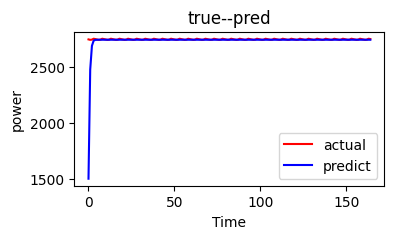

1628247.8545454545

In [42]:
model.eval()
test_outputs = model(test_tensor).detach().numpy()
test_outputs = list(test_outputs[0,:,0])
# print("平均：",MSE(train,train.mean()),MSE(test,test.mean()))
MSE(test,test_outputs)

In [85]:
# 构建双层LSTMcell
# input_size, hidden_size, num_layers, output_size
class LstmCellModel(nn.Module):
    def __init__(self, input_size=1, hidden_size1=100, hidden_size2=50, output_size=1, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.lstm0 = nn.LSTMCell(input_size, hidden_size1)
        self.lstm1 = nn.LSTMCell(hidden_size1, hidden_size2)
        self.fc = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        batch_size, seq_len = x.size(1), x.size(0)
        # 四个初始化参数
        h_10 = torch.randn(seq_len,batch_size,  self.hidden_size1).requires_grad_()
        c_10 = torch.randn(seq_len,batch_size,  self.hidden_size1).requires_grad_()
        h_11 = torch.randn(seq_len,batch_size,  self.hidden_size2).requires_grad_()
        c_11 = torch.randn(seq_len,batch_size,  self.hidden_size2).requires_grad_()
        
        outputs = []
        print("seq_len:",seq_len)
        for t in range(seq_len): # 遍历每个时间步
            h_10, c_10 = self.lstm0(x[:, t, :], (h_10, c_10))
            h_10, c_10 = self.dropout(h_10), self.dropout(c_10)
            h_11, c_11 = self.lstm1(h_10, (h_11, c_11))
            h_11, c_11 = self.dropout(h_11), self.dropout(c_11)
            outputs.append(h_11)
        return self.fc(outputs[-1])       

In [86]:
model = LstmCellModel()
train_tensor = train_tensor.view(train_tensor.shape[0],1,1)
print(train_tensor.size())
model(train_tensor).size()

torch.Size([335, 1, 1])
seq_len: 335


RuntimeError: hidden0 has inconsistent hidden_size: got 1, expected 100